<a href="https://colab.research.google.com/github/hscrown/madatpublicdata/blob/main/collaborative_filtering_%EC%97%B0%EC%8A%B5(6)_%EC%9E%A0%EC%9E%AC%EC%9A%94%EC%9D%B8%EA%B8%B0%EB%B0%98_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

잠재요인기반 협업 필터링  

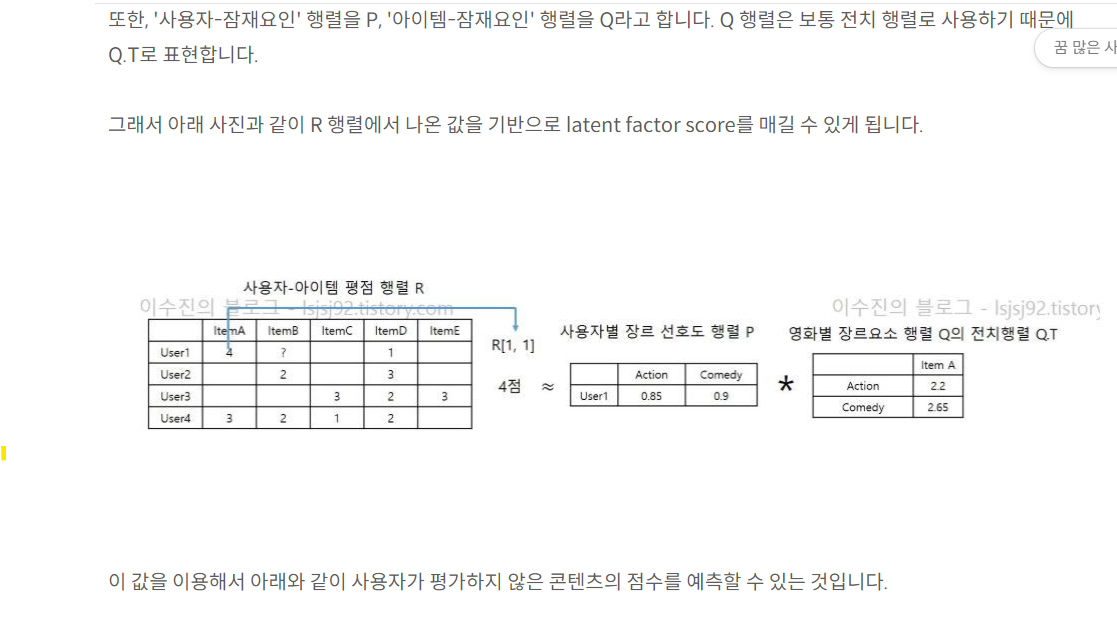

In [1]:
!pip install datasets

from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from datasets import load_dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


## 데이터로드 및 전처리

도서관데이터

In [2]:
# 필요한 컬럼 # 시설명, 구이름, 장소구분
lib = pd.read_csv('seoul_libs.csv', encoding='utf-8')
lib.head()

# 밸류값이 모두 'lib'인 ['type'] 칼럼 추가
lib['type'] = 'lib'

# 컬럼명 변경
cols= {'도서관 일련번호':'place_id', '도서관명':'place_name', '구명':'gu_name'}
lib = lib.rename(columns=cols)
lib.columns

# # 필요한 컬럼만 추출
lib=lib[['place_name', 'gu_name', 'type']]
lib.head()


,place_name,gu_name,type
0,BIBLIOTECA,강남구,lib
1,LH강남3단지작은도서관,강남구,lib
2,休+밤토리SH작은도서관,강남구,lib
3,강남구립못골도서관,강남구,lib
4,강남데시앙파크작은도서관,강남구,lib


공원데이터

In [3]:
# 필요한 컬럼 # 시설명, 구이름, 장소구분
par = pd.read_csv('seoul_parks.csv', encoding='utf-8')
par.head()
par.columns
# 밸류값이 모두 'par'인 ['type'] 칼럼 추가
par['type'] = 'par'

# 컬럼명 변경
cols= {'공원명':'place_name', '공원주소':'gu_name'}
par = par.rename(columns=cols)
par.columns

# 공원주소 컬럼에서 구 이름만 추출
par['gu_name'] = par['gu_name'].str.split(' ', expand=True)[1]

# 결측치 삭제
par = par.dropna()

# gu_name이 '구'로 끝나지 않으면 삭제
par = par[par['gu_name'].str.endswith('구')]

# # 필요한 컬럼만 추출
par=par[['place_name', 'gu_name', 'type']]
par.head()

,place_name,gu_name,type
0,남산도시자연공원,중구,par
12,여의도근린공원,영등포구,par
16,보라매근린공원,동작구,par
17,어린이대공원,광진구,par
18,천호근린공원,강동구,par


박물관, 미술관 데이터

In [ ]:
dataset = load_dataset("hscrown/seoul_museums")
muse = pd.DataFrame(dataset['train'])

muse.columns

# 밸류값이 모두 'muse'인 ['type'] 칼럼 추가
muse['type'] = 'muse'

# 컬럼명 변경
cols= {'시설명':'place_name', '주소':'gu_name'}
muse = muse.rename(columns=cols)

# 주소 컬럼에서 구 이름만 추출
muse['gu_name'] = muse['gu_name'].str.split(' ', expand=True)[1]

# gu_name이 '구'로 끝나지 않으면 삭제
muse = muse[muse['gu_name'].str.endswith('구')]
# # 필요한 컬럼만 추출
muse=muse[['place_name', 'gu_name', 'type']]

muse.tail()

In [ ]:
# 공원데이터와 도서관 데이터 합침
df = pd.concat([lib, par,muse])
df.tail()

# 인덱스 초기화
df = df.reset_index(drop=True)

# 'place_id' 컬럼 만들고 인덱스 밸류로 넣기
df['place_id'] = df.index

df.head()

# df 를 csv 파일로 변환
df.to_csv('places.csv', index=False, encoding='utf-8')

In [ ]:
df.tail()

# 사용자 평점데이터 만들기

In [ ]:
# df 이용해서 사용자 평점데이터 만들기
# place_id,user_id,rating

# user 수 만큼 df 복사하기

user1 = df.copy()

user1.shape # (1663, 4)

user1.columns # ['place_name', 'gu_name', 'type', 'place_id']

# place_name 칼럼 삭제
user1.drop(columns='place_name', inplace=True)

# gu_name은 user_id로, type는 rating으로 컬럼명 변경
user1.columns = ['user_id', 'rating','place_id']
user1['user_id'] = 0

user2 = user1.copy()
user3 = user2.copy()

user2['user_id'] = 1
user3['user_id'] = 2

# user1, user2, user3 데이터 합치기

user_rating = pd.concat([user1, user2, user3])

user_rating

user_rating.columns # ['place_name', 'gu_name', 'type', 'place_id']
# rating 컬럼에 nan 값에 0 넣기
user_rating['rating'] = user_rating['rating'].fillna(0)

# rating 컬럼에 0~5 사이의 실수 랜덤값 넣기. 1의 자리에서 반올림
# numpy 사용
user_rating['rating'] = np.round(np.random.uniform(0, 5, size=len(user_rating)), 1)

# 800개의 엔트리를 랜덤으로 선택하여 'rating' 값을 0.0으로 설정
indices_to_zero = np.random.choice(user_rating.index, size=800, replace=False)
user_rating.loc[indices_to_zero, 'rating'] = 0


user_rating.head()


아이템-특성 데이터 만들기

In [ ]:
# place_id, type, place_name만 추출
item_feature = df[['place_id', 'type', 'place_name','gu_name']]
item_feature.head()

# 추천시스템구현

데이터확인

In [ ]:
# 사용자-장소 평점기반데이터
user_rating.shape  # (4989, 3)

In [ ]:
# 장소 정보 데이터
item_feature = item_feature[['place_id','place_name']]
item_feature

In [ ]:
user_place_data = pd.merge(user_rating, item_feature, on='place_id')
user_place_data.head()

In [ ]:
user_place_data.shape # (4989, 4)

In [ ]:
# 사용자-평점데이터로 변경
df_user_place_ratings = user_place_data.pivot_table(index='user_id', columns='place_id', values='rating')
df_user_place_ratings.head()

여기까지는 앞서 했던 것과 똑같습니다. 사용자-영화 pivot table을 만드는 것이죠.

이제 아래와 같이 데이터를 조금 변경해서 진행하겠습니다.

pivot table을 matrix로 변환
np.mean(axis = 1)을 통해 각 사용자들이 매기는 평점 평균을 구함
1에서 구한 값과 2에서 구한 값을 빼서 사용자-평균 데이터 값을 변경

In [ ]:
print(df_user_place_ratings.columns.dtype)

In [ ]:
print(df_user_place_ratings.columns.dtype)

In [ ]:
df_user_place_ratings.columns = df_user_place_ratings.columns.astype(str)

In [ ]:
# matrix는 pivot_table 값을 numpy matrix로 만든 것
df_user_place_ratings.columns = df_user_place_ratings.columns.str.strip() # 화이트스페이스 지우기
matrix = df_user_place_ratings.values #as_matrix function은 depricated.
matrix
# # user_ratings_mean은 사용자의 평균 평점
user_ratings_mean = np.mean(matrix, axis = 1)

# # R_user_mean : 사용자-영화에 대해 사용자 평균 평점을 뺀 것.
matrix_user_mean = matrix - user_ratings_mean.reshape(-1, 1)

In [ ]:
matrix

In [ ]:
matrix.shape # (3, 1663)

In [ ]:
user_ratings_mean.shape

In [ ]:
matrix_user_mean.shape

In [ ]:
pd.DataFrame(matrix_user_mean, columns = df_user_place_ratings.columns).head()

여기까지 진행하면 초기에 만들었던 user-place pivot table 값이 matrix_user_mean 로 변경된것임.

사용자 3명이 1663개의 영화에 대해 평점을 매긴 값이 존재
사용자 3명의 각각 평균 평점을 구해서
사용자 3명의 1663개의 장소에 대해 평점을 조금 변경 -> 1에서 구한 값 - 2에서 구한 값
이제 SVD를 이용해 Matrix Factorization을 진행

4번에서는 scikit learn을 이용해 TruncatedSVD를 이용했는데요. 이번에는 scipy를 이용해 Truncated SVD를 구해봅니다.

이 둘의 차이점은 scikit learn에서 제공해주는 TruncatedSVD는 U, Sigma, Vt 반환 값을 제공하지 않습니다.
하지만, Scipy를 이용하면 이 반환값들을 제공받을 수 있죠.

Scipy에서 제공해주는 Truncate SVD는 scipy.sparse.linalg.svds를 이용하면 됩니다. 저는 이것을 이용했습니다.

이렇게 사용하면 반환값이 U 행렬, Sigma 행렬, V 전치 행렬(Vt)가 나오게 됩니다.

In [ ]:

# scipy에서 제공해주는 svd.
# U 행렬, sigma 행렬, V 전치 행렬을 반환.

U, sigma, Vt = svds(matrix_user_mean, k = 1)

In [ ]:
print(U.shape)
print(sigma.shape)
print(Vt.shape)
# 현재 이 Sigma 행렬은 0이 아닌 값만 1차원 행렬로 표현된 상태입니다.
# 즉, 0이 포함된 대칭행렬로 변환할 때는 numpy의 diag를 이용해야 합니다.

In [ ]:

sigma = np.diag(sigma)

In [ ]:
sigma.shape

In [ ]:

sigma[0]

In [ ]:

sigma[1]

이렇게 대칭 행렬로 변환이 되었습니다.

현재 까지 상황을 정리하면 아래와 같습니다.

원본 user-movie 평점 행렬이 있었음
이를 user의 평균 점수를 빼서 matrix_user_mean 이라는 행렬로 만듬
2번의 값을 SVD를 적용해 U, Sigma, Vt 행렬을 구했음
Sigma 행렬은 현재 0이 포함이 되지 않은 값으로만 구성되어 있음. 이를 대칭행렬로 변환
자! 이제 여기서 matrix_user_mean을 SVD를 적용해 분해를 한 상태입니다.
이제, 다시 원본 행렬로 복구시켜야겠죠?

원본 행렬로 복구시키는 방법은 아래와 같습니다.

U, Sigma, Vt의 내적을 수행
즉, np.dot(np.dot(U, sigma), Vt)를 수행하면 됩니다.

그리고 아까 사용자 평균을 빼주었으니 여기서는 더해줍니다.

In [ ]:
# U, Sigma, Vt의 내적을 수행하면, 다시 원본 행렬로 복원이 된다.
# 거기에 + 사용자 평균 rating을 적용한다.
svd_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [ ]:
df_svd_preds = pd.DataFrame(svd_user_predicted_ratings, columns = df_user_place_ratings.columns)
df_svd_preds.head()

In [ ]:
df_svd_preds.shape


자! 이제 함수를 하나 만듭니다. 이 함수의 기능은 아래와 같습니다.

인자로 사용자 아이디, 영화 정보 테이블, 평점 테이블 등을 받음
사용자 아이디에 SVD로 나온 결과의 영화 평점이 가장 높은 데이터 순으로 정렬
사용자가 본 데이터를 제외
사용자가 안 본 영화에서 평점이 높은 것을 추천

In [ ]:
def recommend_places(df_svd_preds, user_id, ori_places_df, ori_ratings_df, num_recommendations=5):

    # 사용자의 예측 평점이 높은 순으로 정렬된 데이터
    user_row_number = user_id -1
    sorted_user_predictions = df_svd_preds.iloc[user_row_number].sort_values(ascending=False)

    # 원본 평점 데이터에서 user id에 해당하는 데이터를 추출
    user_data = ori_ratings_df[ori_ratings_df['user_id'] == user_id]

    # 추출된 데이터와 원본 장소 데이터를 합침
    user_history = user_data.merge(ori_places_df, on='place_id').sort_values(['rating'], ascending=False)

    # 사용자가 평가하지 않은 장소를 추천 대상으로 설정
    recommendations = ori_places_df[~ori_places_df['place_id'].isin(user_history['place_id'])]

    # sorted_user_predictions과 recommendations를 합침
    recommendations = recommendations.merge(pd.DataFrame(sorted_user_predictions).reset_index(), on='place_id')

    return user_history, recommendations


In [ ]:
already_rated, predictions = recommend_places(df_svd_preds, 0, df, user_rating, 50)

In [ ]:
already_rated.tail()

In [ ]:
predictions